In [1]:
!pip install pymc
!pip install --upgrade setuptools
!pip install arviz
!pip install fancyimpute
!pip install pandas --upgrade
!pip install seaborn
import pandas as pd
import numpy as np
import pymc as pm
from scipy.stats import binom
import arviz as az
from fancyimpute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
int32 = np.int32

# read in the police reports and real-time crime center data
pr = pd.read_csv("../data/police_reports/electronic_police_report_2018_2022.csv")
rtcc = pd.read_csv("../data/real_time_crime_center/rtcc.csv")
rtcc["rtcc_requested"] = 1 

# create a new column in the police reports data indicating whether the offender is Black
pr['race_black'] = (pr['offender_race'] == 'BLACK')

# select only the necessary columns from the police reports data and join with the distinct item numbers from the rtcc data
rc = pd.merge(pr, rtcc, on="item_number", how="left")

rc['rtcc_requested'] = rc['rtcc_requested'].fillna(0)

rc.loc[:, "rtcc_requested"] = rc.rtcc_requested.astype(str).str.replace(r"\.0", "", regex=True)
rc.loc[:, "offenderid"] = rc.offenderid.astype(str).str.replace(r"\.0", "", regex=True)

rc = rc[~((rc.charge_description.fillna("") == ""))]
rc = rc[~((rc.item_number.fillna("") == ""))]

# Replace empty and 'unknown' strings with NaN
rc['offender_race'] = rc['offender_race'].replace('', np.nan).fillna(value=np.nan, inplace=False)
rc['offender_race'] = rc['offender_race'].replace('UNKNOWN', np.nan)

# Create a new dataframe with only the 'district' and 'offender_race' columns
subset_df = rc[['district', 'offender_race']]

# Split the data into known and unknown values based on the missing values in the 'offender_race' column
known = subset_df[subset_df['offender_race'].notna()]
unknown = subset_df[subset_df['offender_race'].isna()]

# Encode categorical data using LabelEncoder
le = LabelEncoder()
known['district'] = le.fit_transform(known['district'])
known['offender_race'] = le.fit_transform(known['offender_race'])

# Impute missing values using IterativeImputer
imputer = IterativeImputer()
imputed_values = imputer.fit_transform(known)

# Convert imputed values back to dataframe
imputed_df = pd.DataFrame(imputed_values, columns=['district', 'offender_race'])
imputed_df['district'] = imputed_df['district'].astype(int)
imputed_df['offender_race'] = imputed_df['offender_race'].round().astype(int)

# Convert the numerical data back to categorical data using LabelEncoder's inverse_transform method
imputed_df['offender_race'] = le.inverse_transform(imputed_df['offender_race'])

# Replace the missing values in the original 'offender_race' column with the imputed values
rc.loc[unknown.index, 'offender_race'] = imputed_df['offender_race']

df_0 = rc[rc['rtcc_requested'] == "0"]
df_1 = rc[rc['rtcc_requested'] == '1']

rc = pd.concat([df_0, df_1])
print(rc.shape)

rc = rc.drop_duplicates(subset=["item_number", "offenderid"])
rc.loc[:, "rtcc_requested"] = rc.rtcc_requested.astype(int)

rc_grouped = rc.groupby(['race_black', 'charge_description']).agg(n=('item_number', 'count'), rtcc=('rtcc_requested', 'sum')).reset_index()
rc_grouped['race_charge'] = pd.Categorical(rc_grouped['race_black'].astype(str) + '_' + rc_grouped['charge_description'])

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: setuptools in /home/ayyubi/.local/lib/python3.7/site-packages (67.7.2)
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /opt/anaconda3/lib/python3.7/site-packages (1.3.5)
Defaulting to user installation because normal site-packages is not writeable


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (13,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(260715, 28)


In [2]:
with pm.Model() as model:
    # set the prior for the regression coefficients
    b = pm.Normal('b', mu=0, tau=1/5)
    b_race = pm.Normal('b_race', mu=0, tau=1/5)
    
    # set the prior for the standard deviation of the intercept
    sd_intercept = pm.Uniform('sd_intercept', lower=0, upper=10)
    
    # define n as a data input
    n = pm.Data('n', rc_grouped['n'].values)
    
    # define race_black as a predictor
    race_black = pm.Data('race_black', rc_grouped['race_black'].astype(int).values, mutable=True)

    
    # define charge_description as a categorical variable
    charge_descr = rc_grouped['charge_description'].astype('category')
    charge_descr_cats = charge_descr.cat.categories.values
    charge_descr_ints = charge_descr.cat.codes.values
    
    # model the intercept as a normal distribution with a group-level standard deviation
    intercept = pm.Normal('intercept', mu=0, sigma=sd_intercept, shape=len(charge_descr_cats))
    
    # model the effects of the charge descriptions
    charge_effect = pm.Normal('charge_effect', mu=0, tau=1/5, shape=len(charge_descr_cats))
    
    # calculate the linear predictor
    lp = intercept[charge_descr_ints] + b * race_black + b_race * race_black + charge_effect[charge_descr_ints]
    
    # model the counts of RTCC requests as a binomial distribution
    p = pm.math.invlogit(lp)
    rtcc_est = pm.Deterministic('rtcc_est', p * n)
    pm.Binomial('rtcc', n=n, p=p, observed=rc_grouped['rtcc'].values)
    
    # set the prior for the standard deviation of the error term
    sigma = pm.Uniform('sigma', lower=0, upper=100)

# perform MCMC sampling
with model:
    trace = pm.sample(2000, tune=2000, chains=4, target_accept=0.9)

/home/ayyubi/.local/lib/python3.7/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  UserWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, b_race, sd_intercept, intercept, charge_effect, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1584 seconds.


In [3]:
var_names = list(trace.posterior.data_vars.keys())
print(var_names)

['b', 'b_race', 'intercept', 'charge_effect', 'sd_intercept', 'sigma', 'rtcc_est']


In [4]:
az.summary(trace.posterior, var_names=['b_race', 'charge_effect'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_race,0.191,1.596,-2.839,3.098,0.020,0.016,6395.0,6364.0,1.0
charge_effect[0],-1.092,2.125,-5.114,2.871,0.020,0.021,11072.0,6637.0,1.0
charge_effect[1],-0.972,2.162,-4.910,3.147,0.021,0.021,10261.0,6187.0,1.0
charge_effect[2],-0.545,2.075,-4.570,3.169,0.026,0.021,6324.0,6004.0,1.0
charge_effect[3],0.153,2.077,-3.634,4.147,0.023,0.021,7937.0,6402.0,1.0
...,...,...,...,...,...,...,...,...,...
charge_effect[536],-0.876,2.091,-4.775,3.131,0.026,0.021,6685.0,5844.0,1.0
charge_effect[537],-1.104,2.094,-5.051,2.751,0.021,0.020,10315.0,6679.0,1.0
charge_effect[538],-1.072,2.066,-4.864,2.897,0.026,0.021,6229.0,5304.0,1.0
charge_effect[539],-0.916,2.118,-5.133,2.818,0.021,0.021,9873.0,6308.0,1.0


In [5]:
## add code to filter out charges
charge_summary = az.summary(trace.posterior["charge_effect"], hdi_prob=0.95, round_to=2, var_names=['charge_effect'])
charge_summary = pd.DataFrame(charge_summary)
charge_means = charge_summary.mean()
print(charge_means)

mean           -0.704972
sd              2.096969
hdi_2.5%       -4.795860
hdi_97.5%       3.393549
mcse_mean       0.022662
mcse_sd         0.020092
ess_bulk     9289.163216
ess_tail     6165.241423
r_hat           1.000000
dtype: float64


In [6]:
## add code to filter out charges
race_summary = az.summary(trace.posterior["b_race"], hdi_prob=0.95, round_to=2, var_names=['b_race'])
race_summary = pd.DataFrame(race_summary)
race_means = race_summary.mean()
print(race_means)

mean            0.19
sd              1.60
hdi_2.5%       -2.79
hdi_97.5%       3.37
mcse_mean       0.02
mcse_sd         0.02
ess_bulk     6394.62
ess_tail     6363.55
r_hat           1.00
dtype: float64


In [11]:
coef_summary = az.summary(trace.posterior["charge_effect"])
coef_summary.index = rc["charge_description"].unique()

coef_summary = coef_summary[["mean", "hdi_3%", "hdi_97%"]]
coef_summary.columns = ["mean", "q05", "q95"]

## take the median?
coef_summary = coef_summary.sort_values("mean", ascending=False)
print(coef_summary.head(10))

coef_summary = coef_summary.sort_values("mean")
print(coef_summary.head(10))

                                                  mean    q05    q95
ALTERING/REMOVING VIN NUMBER                     0.653 -3.195  4.627
VEHICULAR TRESPASS                               0.652 -3.405  4.580
FOOD/BEVERAGE ON PUBLIC TRANSIT                  0.631 -3.495  4.478
DRIVER'S LICENSE REQUIRED                        0.629 -3.448  4.547
POSSESSION OF A BOMB                             0.608 -3.488  4.743
ATTEMPT - IMPERSONATION                          0.350 -3.581  4.121
UNAUTHORIZED ENTRY OF A CRITICAL INFRASTRUCTURE  0.213 -3.644  4.021
ILLEGAL CARRYING OF WEAPON                       0.153 -3.634  4.147
VEHICLES ENTITLED TO RIGHT OF WAY                0.017 -3.730  3.974
PRINCIPAL TO ATTEMPTED ARMED ROBBERY             0.014 -3.764  4.067
                                              mean    q05    q95
OBSTRUCTING SCHOOL FACILITY STAFF           -1.469 -5.304  2.587
PRINCIPAL TO FIRST DEGREE RAPE              -1.468 -5.347  2.596
CONSPIRACY TO POSSESSION OF SCHEDULE IV CDS -1

In [12]:
rc_grouped_holdout = rc_grouped[rc_grouped['charge_description'] == 'ARMED ROBBERY']

with pm.Model() as model_holdout:
    # set the prior for the regression coefficients
    b = pm.Normal('b', mu=0, tau=1/5) # regression coefficient for race_black
    b_race = pm.Normal('b_race', mu=0, tau=1/5) # regression coefficient for race_black * charge_description

    # set the prior for the standard deviation of the intercept
    sd_intercept = pm.Uniform('sd_intercept', lower=0, upper=10)

    # define n as a data input
    n = pm.Data('n', rc_grouped_holdout['n'].values)

    # define race_black as a predictor
    race_black = pm.Data('race_black', rc_grouped_holdout['race_black'].astype(int).values, mutable=True)

    # model the intercept as a normal distribution with a group-level standard deviation
    intercept = pm.Normal('intercept', mu=0, sigma=sd_intercept)

    # model the effects of the charge descriptions
    charge_descr = pm.Normal('charge_descr', mu=0, tau=1/5, shape=len(charge_descr_cats))

    # calculate the linear predictor
    lp = intercept + b * race_black + b_race * race_black + charge_descr[np.where(charge_descr_cats == 'ARMED ROBBERY')[0][0]]

    # model the counts of RTCC requests as a a binomial distribution
    p = pm.math.invlogit(lp)
    rtcc_est = pm.Deterministic('rtcc_est', p * n)
    rtcc = pm.Binomial('rtcc', n=n, p=p, observed=rc_grouped_holdout['rtcc'].values)

    # set the prior for the standard deviation of the error term
    sigma = pm.Uniform('sigma', lower=0, upper=100)

with model_holdout:
    trace_holdout = pm.sample(2000, tune=2000, chains=4, target_accept=0.9)

/home/ayyubi/.local/lib/python3.7/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  UserWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, b_race, sd_intercept, intercept, charge_descr, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 585 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [14]:
predicted_rtcc = trace_holdout.posterior['rtcc_est'].mean()
expected_rtcc = p.mean() * n.sum()

print('Predicted RTCC requests for ARMED ROBBERY using the holdout model: ', predicted_rtcc)
print('Observed RTCC requests for ARMED ROBBERY: ', rc_grouped_holdout['rtcc'].sum())

Predicted RTCC requests for ARMED ROBBERY using the holdout model:  <xarray.DataArray 'rtcc_est' ()>
array(212.88536339)
Observed RTCC requests for ARMED ROBBERY:  426


In [16]:
# First, we hold out the "ARMED ROBBERY" charge
rc_grouped_holdout = rc_grouped[rc_grouped['charge_description'] == 'ARMED ROBBERY']

# Define the model
with pm.Model() as model_holdout:

    # Set the prior for the regression coefficients
    b = pm.Normal('b', mu=0, tau=1/5)  # regression coefficient for race_black
    b_race = pm.Normal('b_race', mu=0, tau=1/5)  # regression coefficient for race_black * charge_description
    
    # Set the prior for the standard deviation of the intercept
    sd_intercept = pm.Uniform('sd_intercept', lower=0, upper=10)

    # Define n as a data input
    n = pm.Data('n', rc_grouped_holdout['n'].values)

    # Define race_black as a predictor
    race_black = pm.Data('race_black', rc_grouped_holdout['race_black'].astype(int).values, mutable=True)

    # Model the intercept as a normal distribution with a group-level standard deviation
    intercept = pm.Normal('intercept', mu=0, sigma=sd_intercept)

    # Model the effects of the charge descriptions
    charge_descr_cats = np.unique(rc_grouped['charge_description'].values)
    charge_descr = pm.Normal('charge_descr', mu=0, tau=1/5, shape=len(charge_descr_cats))

    # Calculate the linear predictor
    lp = intercept + b * race_black + b_race * race_black * charge_descr[np.where(charge_descr_cats == 'ARMED ROBBERY')[0][0]]

    # Model the counts of RTCC requests as a binomial distribution
    p = pm.math.invlogit(lp)
    rtcc_est = pm.Deterministic('rtcc_est', p * n)
    rtcc = pm.Binomial('rtcc', n=n, p=p, observed=rc_grouped_holdout['rtcc'].values)

    # Set the prior for the standard deviation of the error term
    sigma = pm.Uniform('sigma', lower=0, upper=100)

    # Perform MCMC sampling
    trace_holdout = pm.sample(2000, tune=2000)

with model_holdout:
    race_black.set_value(np.atleast_1d(0).astype(int32))  # set race_black to 0 (white)
    ppc_white = pm.sample_posterior_predictive(trace_holdout)
    race_black.set_value(np.atleast_1d(1).astype(int32))  # set race_black to 1 (black)
    ppc_black = pm.sample_posterior_predictive(trace_holdout)

/home/ayyubi/.local/lib/python3.7/site-packages/pymc/data.py:676: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  UserWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, b_race, sd_intercept, intercept, charge_descr, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 425 seconds.
There were 417 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6821, but should be close to 0.8. Try to increase the number of tuning steps.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
There were 406 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6889, but should be close to 0.8. Try to increase the number of tuning steps.
There were 325 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.717, but should be close to 0.8. Try to increase the number of tuning steps.


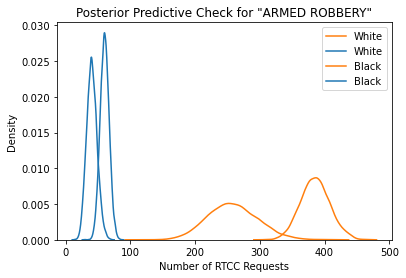

In [17]:
sns.kdeplot(ppc_white.posterior_predictive['rtcc'].values.reshape(-1, 2), label='White')
sns.kdeplot(ppc_black.posterior_predictive['rtcc'].values.reshape(-1, 2), label='Black')
plt.xlabel('Number of RTCC Requests')
plt.ylabel('Density')
plt.title('Posterior Predictive Check for "ARMED ROBBERY"')
plt.legend()
plt.show()